In [285]:
#!/usr/bin/env python3
"""
process_listener_data.py - Process jsPsych listener experiment data

Takes a folder of individual participant CSV files and combines them into
a single wide-format table (one row per participant), similar to Qualtrics output.

Usage:
    python process_listener_data.py <input_folder> [output_file]
    
Example:
    python process_listener_data.py ./data ./processed_data.csv
"""

import os
import sys
import json
import pandas as pd
from pathlib import Path
from datetime import datetime


def parse_json_response(response_str):
    """Parse JSON response string, handling various formats."""
    if pd.isna(response_str) or response_str == '':
        return {}
    try:
        # Handle the jsPsych response format
        if isinstance(response_str, str):
            return json.loads(response_str)
        return response_str
    except (json.JSONDecodeError, TypeError):
        return {}


def process_single_participant(filepath):
    """
    Process a single participant's CSV file and return a dictionary
    with all relevant variables in wide format.
    
    Handles both old and new data formats (with/without datapipe_condition, cell_idx, etc.)
    """
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None
    
    if len(df) == 0:
        return None
    
    result = {}
    
    # =========================================================================
    # METADATA (from first row with completion info)
    # =========================================================================
    meta_cols = [
        'subject_id', 'prolific_pid', 'study_id', 'session_id',
        'experiment_version', 'start_time', 'completion_status', 
        'completion_time', 'terminated_early', 'termination_reason',
        'speaker_condition', 'listener_belief_condition', 
        'sequence_idx', 'measure_order',
        # New columns in updated experiment
        'datapipe_condition', 'cell_idx'
    ]
    
    for col in meta_cols:
        if col in df.columns:
            # Get first non-empty value (excluding 'null' strings)
            non_empty = df[df[col].notna() & (df[col] != '') & (df[col] != 'null')][col]
            result[col] = non_empty.iloc[0] if len(non_empty) > 0 else None
    
    # Calculate total experiment duration
    if 'time_elapsed' in df.columns:
        result['total_duration_ms'] = df['time_elapsed'].max()
        result['total_duration_min'] = result['total_duration_ms'] / 60000 if result['total_duration_ms'] else None
    
    # =========================================================================
    # COMPREHENSION CHECKS
    # =========================================================================
    
    # comp1_some - "some" definition check
    comp1_some = df[df['task'] == 'comp1_some']
    if len(comp1_some) > 0:
        result['comp1_some_correct'] = comp1_some['comp1_some_correct'].iloc[0]
        # Get their response
        resp = parse_json_response(comp1_some['response'].iloc[0])
        result['comp1_some_response'] = resp.get('some_def', None)
    
    # comp1_most - "most" definition check
    comp1_most = df[df['task'] == 'comp1_most']
    if len(comp1_most) > 0:
        result['comp1_most_correct'] = comp1_most['comp1_most_correct'].iloc[0]
        resp = parse_json_response(comp1_most['response'].iloc[0])
        result['comp1_most_response'] = resp.get('most_def', None)
    
    # comp2_tf - True/False check (single image)
    comp2 = df[df['task'] == 'comp2_tf']
    if len(comp2) > 0:
        result['comp2_correct'] = comp2['comp2_correct'].iloc[0]
    
    # comp_multiple_desc - Multiple descriptions check
    comp_multi = df[df['task'] == 'comp_multiple_desc']
    if len(comp_multi) > 0:
        result['comp_multi_correct'] = comp_multi['comp_correct'].iloc[0]
        result['comp_multi_selected'] = comp_multi['selected'].iloc[0]
    
    # comp3 - Which trials make statement true
    comp3 = df[df['task'] == 'comp3']
    if len(comp3) > 0:
        result['comp3_correct'] = comp3['comp3_correct'].iloc[0]
        result['comp3_selected'] = comp3['selected'].iloc[0]
    
    # Truth comprehension check
    truth_comp = df[df['task'] == 'truth_comprehension']
    if len(truth_comp) > 0:
        result['truth_comp_correct'] = truth_comp.get('truth_check_correct', pd.Series([None])).iloc[0]
    
    # =========================================================================
    # MAIN TRIAL DATA (rounds 1-5)
    # =========================================================================
    
    # Combined measure (vigilant condition) or point_estimate_effectiveness (other conditions)
    trial_tasks = ['combined_measure', 'point_estimate_effectiveness']
    trials = df[df['task'].isin(trial_tasks)]
    
    for _, row in trials.iterrows():
        round_num = row.get('round', None)
        if pd.isna(round_num) or round_num == '':
            continue
        round_num = int(round_num)
        
        prefix = f'r{round_num}'
        
        # Utterance info
        result[f'{prefix}_utterance_predicate'] = row.get('utterance_predicate', None)
        result[f'{prefix}_utterance_quantifier'] = row.get('utterance_quantifier', None)
        result[f'{prefix}_utterance_text'] = row.get('utterance_text', None)
        
        # Responses
        result[f'{prefix}_effectiveness'] = row.get('effectiveness_point_estimate', None)
        
        # Speaker type (may be empty for non-vigilant conditions)
        speaker_type = row.get('speaker_type_point_estimate', None)
        if speaker_type and speaker_type != '' and speaker_type != 'null':
            result[f'{prefix}_speaker_type'] = speaker_type
        else:
            result[f'{prefix}_speaker_type'] = None
        
        # RT (if available)
        if 'rt' in row and row['rt'] not in [None, '', 'null']:
            try:
                result[f'{prefix}_rt'] = float(row['rt'])
            except (ValueError, TypeError):
                result[f'{prefix}_rt'] = None
    
    # Separate speaker goal page (if exists, for older version)
    speaker_goal_trials = df[df['task'] == 'point_estimate_speaker_goal']
    for _, row in speaker_goal_trials.iterrows():
        round_num = row.get('round', None)
        if pd.isna(round_num) or round_num == '':
            continue
        round_num = int(round_num)
        prefix = f'r{round_num}'
        
        # Only fill if not already filled by combined_measure
        if f'{prefix}_speaker_type' not in result or result[f'{prefix}_speaker_type'] is None:
            result[f'{prefix}_speaker_type'] = row.get('speaker_type_point_estimate', None)
    
    # =========================================================================
    # ATTENTION CHECK
    # =========================================================================
    
    attention = df[df['task'] == 'attention_check']
    if len(attention) > 0:
        row = attention.iloc[0]
        result['attention_check_passed'] = row.get('attention_check_passed', None)
        result['attention_effectiveness'] = row.get('effectiveness_point_estimate', None)
        
        # Speaker type may be null for non-vigilant conditions
        speaker_type = row.get('speaker_type_point_estimate', None)
        if speaker_type and speaker_type != '' and speaker_type != 'null':
            result['attention_speaker_type'] = speaker_type
        else:
            result['attention_speaker_type'] = None
    
    # =========================================================================
    # COMPETENCE RATING
    # =========================================================================
    
    competence = df[df['task'] == 'competence_rating']
    if len(competence) > 0:
        row = competence.iloc[0]
        result['competence_score'] = row.get('competence_score', None)
        result['competence_framing'] = row.get('competence_framing', None)
        
        # NEW: estimation_strategy may now be stored directly in this row
        if 'estimation_strategy' in row and pd.notna(row['estimation_strategy']) and row['estimation_strategy'] != '':
            result['open_estimation_strategy'] = row['estimation_strategy']
    
    # =========================================================================
    # PERSUASIVE SPEAKER REVEAL (vigilant + persuasive only)
    # =========================================================================
    
    reveal = df[df['task'] == 'persuasive_speaker_reveal']
    result['saw_persuasive_reveal'] = len(reveal) > 0
    
    # =========================================================================
    # OPEN-ENDED RESPONSES
    # =========================================================================
    
    survey_text = df[df['trial_type'] == 'survey-text']
    for _, row in survey_text.iterrows():
        resp = parse_json_response(row.get('response', ''))
        
        # Vigilant condition questions
        if 'speaker_evaluation_strategy' in resp:
            result['open_speaker_strategy'] = resp['speaker_evaluation_strategy']
        
        # Other conditions question (old format where it's in survey-text)
        if 'estimation_strategy' in resp:
            # Only set if not already set from competence_rating row
            if 'open_estimation_strategy' not in result or result['open_estimation_strategy'] is None:
                result['open_estimation_strategy'] = resp['estimation_strategy']
        
        # General feedback (all conditions)
        if 'feedback' in resp:
            result['open_feedback'] = resp['feedback']
    
    # =========================================================================
    # DERIVED VARIABLES
    # =========================================================================
    
    # Count how many rounds completed
    completed_rounds = sum(1 for i in range(1, 6) 
                          if result.get(f'r{i}_effectiveness') is not None)
    result['n_rounds_completed'] = completed_rounds
    
    # Did they complete all rounds?
    result['completed_all_rounds'] = completed_rounds == 5
    
    # Calculate comprehension score (out of 5 checks)
    comp_checks = [
        result.get('comp1_some_correct'),
        result.get('comp1_most_correct'),
        result.get('comp2_correct'),
        result.get('comp_multi_correct'),
        result.get('comp3_correct')
    ]
    result['n_comp_correct'] = sum(1 for c in comp_checks if c == True or c == 'true')
    
    return result


def process_folder(input_folder, output_file=None):
    """
    Process all CSV files in a folder and combine into a single DataFrame.
    """
    input_path = Path(input_folder)
    
    if not input_path.exists():
        print(f"Error: Input folder '{input_folder}' does not exist.")
        return None
    
    # Find all CSV files
    csv_files = list(input_path.glob('*.csv'))
    
    if len(csv_files) == 0:
        print(f"Error: No CSV files found in '{input_folder}'")
        return None
    
    print(f"Found {len(csv_files)} CSV files to process...")
    
    # Process each file
    all_results = []
    errors = []
    
    for i, filepath in enumerate(csv_files):
        if (i + 1) % 10 == 0:
            print(f"  Processing {i + 1}/{len(csv_files)}...")
        
        result = process_single_participant(filepath)
        if result is not None:
            result['source_file'] = filepath.name
            all_results.append(result)
        else:
            errors.append(filepath.name)
    
    print(f"\nSuccessfully processed: {len(all_results)} participants")
    if errors:
        print(f"Errors: {len(errors)} files")
        for err in errors[:5]:
            print(f"  - {err}")
        if len(errors) > 5:
            print(f"  ... and {len(errors) - 5} more")
    
    # Create DataFrame
    df = pd.DataFrame(all_results)
    
    # Reorder columns for readability
    col_order = [
        # Metadata
        'source_file', 'subject_id', 'prolific_pid', 'study_id', 'session_id',
        'experiment_version', 'start_time', 'completion_status', 'completion_time',
        'terminated_early', 'termination_reason', 'total_duration_ms', 'total_duration_min',
        # New metadata columns
        'datapipe_condition', 'cell_idx',
        
        # Conditions
        'speaker_condition', 'listener_belief_condition', 'sequence_idx', 'measure_order',
        
        # Comprehension
        'comp1_some_correct', 'comp1_some_response',
        'comp1_most_correct', 'comp1_most_response',
        'comp2_correct', 'comp_multi_correct', 'comp_multi_selected',
        'comp3_correct', 'comp3_selected', 'truth_comp_correct', 'n_comp_correct',
        
        # Rounds 1-5
        'r1_utterance_predicate', 'r1_utterance_quantifier', 'r1_utterance_text',
        'r1_effectiveness', 'r1_speaker_type', 'r1_rt',
        'r2_utterance_predicate', 'r2_utterance_quantifier', 'r2_utterance_text',
        'r2_effectiveness', 'r2_speaker_type', 'r2_rt',
        'r3_utterance_predicate', 'r3_utterance_quantifier', 'r3_utterance_text',
        'r3_effectiveness', 'r3_speaker_type', 'r3_rt',
        'r4_utterance_predicate', 'r4_utterance_quantifier', 'r4_utterance_text',
        'r4_effectiveness', 'r4_speaker_type', 'r4_rt',
        'r5_utterance_predicate', 'r5_utterance_quantifier', 'r5_utterance_text',
        'r5_effectiveness', 'r5_speaker_type', 'r5_rt',
        
        # Completion
        'n_rounds_completed', 'completed_all_rounds',
        
        # Attention check
        'attention_check_passed', 'attention_effectiveness', 'attention_speaker_type',
        
        # Final measures
        'competence_score', 'competence_framing', 'saw_persuasive_reveal',
        
        # Open-ended
        'open_speaker_strategy', 'open_estimation_strategy', 'open_feedback',
    ]
    
    # Only include columns that exist
    existing_cols = [c for c in col_order if c in df.columns]
    other_cols = [c for c in df.columns if c not in col_order]
    df = df[existing_cols + other_cols]
    
    # Save if output file specified
    if output_file:
        df.to_csv(output_file, index=False)
        print(f"\nSaved to: {output_file}")
    
    return df


def main():
    """Main entry point."""
    if len(sys.argv) < 2:
        print(__doc__)
        sys.exit(1)
        
    input_folder = './raw_do_not_track/prag_net_listener_n1_main'
    output_file = './raw_do_not_track/processed_listener_n1_full.csv'
    
    
    if output_file is None:
        # Default output filename
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_file = f'processed_listener_data_{timestamp}.csv'
    
    df = process_folder(input_folder, output_file)
    
    if df is not None:
        print(f"\n=== Summary ===")
        print(f"Total participants: {len(df)}")
        
        if 'completion_status' in df.columns:
            print(f"\nCompletion status:")
            print(df['completion_status'].value_counts().to_string())
        
        if 'listener_belief_condition' in df.columns:
            print(f"\nListener belief conditions:")
            print(df['listener_belief_condition'].value_counts().to_string())
        
        if 'speaker_condition' in df.columns:
            print(f"\nSpeaker conditions:")
            print(df['speaker_condition'].value_counts().to_string())
        
        if 'attention_check_passed' in df.columns:
            print(f"\nAttention check:")
            print(df['attention_check_passed'].value_counts().to_string())
    
    return df


if __name__ == '__main__':
    df = main()


def add_participant_id(df):
    """Add participant_id column (P001, P002, etc.) at the beginning."""
    df = df.copy()
    df.insert(0, 'participant_id', [f'P{i+1:03d}' for i in range(len(df))])
    return df

df = add_participant_id(df)
df.to_csv('./raw_do_not_track/processed_listener_n1_full.csv', index=False)

Found 634 CSV files to process...
  Processing 10/634...
  Processing 20/634...
  Processing 30/634...
  Processing 40/634...
  Processing 50/634...
  Processing 60/634...
  Processing 70/634...
  Processing 80/634...
  Processing 90/634...
  Processing 100/634...
  Processing 110/634...
  Processing 120/634...
  Processing 130/634...
  Processing 140/634...
  Processing 150/634...
  Processing 160/634...
  Processing 170/634...
  Processing 180/634...
  Processing 190/634...
  Processing 200/634...
  Processing 210/634...
  Processing 220/634...
  Processing 230/634...
  Processing 240/634...
  Processing 250/634...
  Processing 260/634...
  Processing 270/634...
  Processing 280/634...
  Processing 290/634...
  Processing 300/634...
  Processing 310/634...
  Processing 320/634...
  Processing 330/634...
  Processing 340/634...
  Processing 350/634...
  Processing 360/634...
  Processing 370/634...
  Processing 380/634...
  Processing 390/634...
  Processing 400/634...
  Processing 41

In [286]:
def create_anonymized_version(df):
    """
    Create anonymized version by removing identifying columns.
    Keeps participant_id as the only identifier.
    """
    # Columns to remove for anonymization
    id_columns = ['source_file', 'subject_id', 'prolific_pid', 'study_id', 'session_id']
    
    df_anon = df.copy()
    for col in id_columns:
        if col in df_anon.columns:
            df_anon = df_anon.drop(columns=[col])
    
    return df_anon

df_anon=create_anonymized_version(df)

In [287]:
df_anon.to_csv('./processed_listener_n1_anonymized.csv', index=False)

import pandas as pd

def df_to_r_import_info(df):
    """Analyze DataFrame types and generate R import guidance."""
    
    print("="*60)
    print("DATAFRAME SUMMARY FOR R IMPORT")
    print("="*60)
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
    
    # Type mapping from pandas to R colClasses
    type_map = {
        'int64': 'integer',
        'int32': 'integer',
        'float64': 'numeric',
        'float32': 'numeric',
        'bool': 'logical',
        'object': 'character',
        'category': 'factor',
        'datetime64[ns]': 'Date',  # or POSIXct
    }
    
    r_types = []
    
    print(f"{'Column':<30} {'Pandas Type':<15} {'R Type':<12} {'NAs':<6} {'Sample'}")
    print("-"*90)
    
    for col in df.columns:
        dtype = str(df[col].dtype)
        r_type = type_map.get(dtype, 'character')
        na_count = df[col].isna().sum()
        sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else "NA"
        
        # Truncate sample for display
        sample_str = str(sample)[:20] + "..." if len(str(sample)) > 20 else str(sample)
        
        print(f"{col:<30} {dtype:<15} {r_type:<12} {na_count:<6} {sample_str}")
        r_types.append(f'"{col}" = "{r_type}"')
    
    # Generate R code
    print("\n" + "="*60)
    print("R IMPORT CODE")
    print("="*60)
    
    col_classes = ",\n    ".join(r_types)
    
    print(f'''
# Option 1: Base R
df <- read.csv("your_file.csv", 
  colClasses = c(
    {col_classes}
  ))

# Option 2: readr (faster, often auto-detects well)
library(readr)
df <- read_csv("your_file.csv")
''')

# Usage
df_to_r_import_info(df_anon)

DATAFRAME SUMMARY FOR R IMPORT
Shape: 634 rows, 66 columns

Column                         Pandas Type     R Type       NAs    Sample
------------------------------------------------------------------------------------------
participant_id                 object          character    0      P001
experiment_version             object          character    0      1.0.0
start_time                     object          character    0      2026-02-01T09:41:04....
completion_status              object          character    0      completed
completion_time                object          character    0      2026-02-01T09:48:29....
terminated_early               bool            logical      0      False
termination_reason             object          character    609    attention_check_fail...
total_duration_ms              int64           integer      0      444842
total_duration_min             float64         numeric      0      7.414033333333333
datapipe_condition             float64         n

In [223]:
#!/usr/bin/env python3
"""
visualize_listener_data.py - Visualization functions for listener experiment data

Functions for plotting effectiveness ratings across conditions and rounds.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, List


def plot_effectiveness_by_condition(
    df: pd.DataFrame,
    speaker_condition: str,
    sequence_idx: int,
    figsize: Tuple[int, int] = (15, 10),
    bins: int = 21,
    alpha: float = 0.6,
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Plot histograms of effectiveness ratings for three listener belief conditions,
    subplotted by the five rounds.
    
    Parameters
    ----------
    df : pd.DataFrame
        Processed listener experiment data (wide format, one row per participant)
    speaker_condition : str
        Speaker condition to filter by (e.g., 'informative', 'pers_plus', 'pers_minus')
    sequence_idx : int
        Sequence index to filter by (e.g., 0, 1, 2, ...)
    figsize : tuple
        Figure size (width, height)
    bins : int
        Number of histogram bins (default 21 for 0-100 in steps of 5)
    alpha : float
        Transparency of histogram bars
    save_path : str, optional
        If provided, save figure to this path
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    
    # Filter data for the requested speaker condition and sequence
    mask = (df['speaker_condition'] == speaker_condition) & (df['sequence_idx'] == sequence_idx)
    filtered_df = df[mask].copy()
    
    if len(filtered_df) == 0:
        print(f"Warning: No data found for speaker_condition='{speaker_condition}', sequence_idx={sequence_idx}")
        print(f"Available speaker conditions: {df['speaker_condition'].unique()}")
        print(f"Available sequence indices: {sorted(df['sequence_idx'].unique())}")
        return None
    
    # Define colors for the three conditions
    condition_colors = {
        'vigilant': '#e74c3c',      # Red
        'credulous': '#3498db',     # Blue
        'naturalistic': '#2ecc71'   # Green
    }
    
    condition_labels = {
        'vigilant': 'Vigilant',
        'credulous': 'Credulous', 
        'naturalistic': 'Naturalistic'
    }
    
    # Create figure with 5 subplots (one per round)
    fig, axes = plt.subplots(1, 5, figsize=figsize, sharey=True)
    fig.suptitle(f'Effectiveness Ratings by Condition\n(Speaker: {speaker_condition}, Sequence: {sequence_idx})', 
                 fontsize=14, fontweight='bold')
    
    # Bin edges for histograms (0 to 100 in steps of 5)
    bin_edges = np.linspace(0, 100, bins)
    
    # Track which conditions have data for the legend
    legend_handles = []
    legend_labels = []
    
    for round_num in range(1, 6):
        ax = axes[round_num - 1]
        col_name = f'r{round_num}_effectiveness'
        
        # Plot histogram for each condition
        for condition in ['vigilant', 'credulous', 'naturalistic']:
            condition_data = filtered_df[filtered_df['listener_belief_condition'] == condition][col_name]
            condition_data = condition_data.dropna()
            
            if len(condition_data) > 0:
                counts, _, patches = ax.hist(
                    condition_data, 
                    bins=bin_edges, 
                    alpha=alpha,
                    color=condition_colors[condition],
                    label=condition_labels[condition],
                    edgecolor='white',
                    linewidth=0.5
                )
                
                # Add to legend only once
                if round_num == 1 and condition_labels[condition] not in legend_labels:
                    legend_handles.append(patches[0])
                    legend_labels.append(condition_labels[condition])
        
        # Formatting
        ax.set_xlabel('Effectiveness (%)', fontsize=10)
        ax.set_title(f'Round {round_num}', fontsize=12, fontweight='bold')
        ax.set_xlim(0, 100)
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.grid(axis='y', alpha=0.3)
        
        # Add count annotation
        n_total = len(filtered_df[filtered_df[col_name].notna()])
        ax.text(0.95, 0.95, f'n={n_total}', transform=ax.transAxes, 
                ha='right', va='top', fontsize=9, color='gray')
    
    # Y-axis label only on first subplot
    axes[0].set_ylabel('Count', fontsize=10)
    
    # Add legend
    if legend_handles:
        fig.legend(legend_handles, legend_labels, loc='upper right', 
                   bbox_to_anchor=(0.98, 0.88), fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


def plot_effectiveness_density(
    df: pd.DataFrame,
    speaker_condition: str,
    sequence_idx: int,
    figsize: Tuple[int, int] = (15, 10),
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Plot KDE density plots of effectiveness ratings (smoother alternative to histograms).
    
    Parameters
    ----------
    df : pd.DataFrame
        Processed listener experiment data
    speaker_condition : str
        Speaker condition to filter by
    sequence_idx : int
        Sequence index to filter by
    figsize : tuple
        Figure size
    save_path : str, optional
        If provided, save figure to this path
        
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    
    # Filter data
    mask = (df['speaker_condition'] == speaker_condition) & (df['sequence_idx'] == sequence_idx)
    filtered_df = df[mask].copy()
    
    if len(filtered_df) == 0:
        print(f"Warning: No data found for speaker_condition='{speaker_condition}', sequence_idx={sequence_idx}")
        return None
    
    # Define colors
    condition_colors = {
        'vigilant': '#e74c3c',
        'credulous': '#3498db',
        'naturalistic': '#2ecc71'
    }
    
    # Create figure
    fig, axes = plt.subplots(1, 5, figsize=figsize, sharey=True)
    fig.suptitle(f'Effectiveness Rating Distributions\n(Speaker: {speaker_condition}, Sequence: {sequence_idx})', 
                 fontsize=14, fontweight='bold')
    
    for round_num in range(1, 6):
        ax = axes[round_num - 1]
        col_name = f'r{round_num}_effectiveness'
        
        for condition in ['vigilant', 'credulous', 'naturalistic']:
            condition_data = filtered_df[filtered_df['listener_belief_condition'] == condition][col_name]
            condition_data = condition_data.dropna()
            
            if len(condition_data) > 1:
                sns.kdeplot(
                    data=condition_data,
                    ax=ax,
                    color=condition_colors[condition],
                    label=condition.capitalize(),
                    fill=True,
                    alpha=0.3,
                    linewidth=2,
                    clip=(0, 100)
                )
        
        ax.set_xlabel('Effectiveness (%)', fontsize=10)
        ax.set_title(f'Round {round_num}', fontsize=12, fontweight='bold')
        ax.set_xlim(0, 100)
        ax.grid(axis='y', alpha=0.3)
    
    axes[0].set_ylabel('Density', fontsize=10)
    
    # Add legend from first axis
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right', 
                   bbox_to_anchor=(0.98, 0.88), fontsize=10)
    
    # Remove individual legends
    for ax in axes:
        ax.legend().set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


def plot_effectiveness_summary(
    df: pd.DataFrame,
    speaker_condition: str,
    sequence_idx: int,
    figsize: Tuple[int, int] = (12, 6),
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Plot mean effectiveness with error bars across rounds for each condition.
    
    Parameters
    ----------
    df : pd.DataFrame
        Processed listener experiment data
    speaker_condition : str
        Speaker condition to filter by
    sequence_idx : int
        Sequence index to filter by
    figsize : tuple
        Figure size
    save_path : str, optional
        If provided, save figure to this path
        
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    
    # Filter data
    mask = (df['speaker_condition'] == speaker_condition) & (df['sequence_idx'] == sequence_idx)
    filtered_df = df[mask].copy()
    
    if len(filtered_df) == 0:
        print(f"Warning: No data found for speaker_condition='{speaker_condition}', sequence_idx={sequence_idx}")
        return None
    
    # Define colors
    condition_colors = {
        'vigilant': '#e74c3c',
        'credulous': '#3498db',
        'naturalistic': '#2ecc71'
    }
    
    fig, ax = plt.subplots(figsize=figsize)
    
    rounds = [1, 2, 3, 4, 5]
    x_offset = {'vigilant': -0.15, 'credulous': 0, 'naturalistic': 0.15}
    
    for condition in ['vigilant', 'credulous', 'naturalistic']:
        condition_data = filtered_df[filtered_df['listener_belief_condition'] == condition]
        
        means = []
        sems = []
        
        for r in rounds:
            col = f'r{r}_effectiveness'
            data = condition_data[col].dropna()
            means.append(data.mean() if len(data) > 0 else np.nan)
            sems.append(data.sem() if len(data) > 1 else 0)
        
        x_positions = [r + x_offset[condition] for r in rounds]
        
        ax.errorbar(
            x_positions, means, yerr=sems,
            marker='o', markersize=8, capsize=5,
            color=condition_colors[condition],
            label=f'{condition.capitalize()} (n={len(condition_data)})',
            linewidth=2
        )
    
    ax.set_xlabel('Round', fontsize=12)
    ax.set_ylabel('Mean Effectiveness Rating (%)', fontsize=12)
    ax.set_title(f'Effectiveness Ratings by Condition\n(Speaker: {speaker_condition}, Sequence: {sequence_idx})', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(rounds)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0, 100)
    ax.legend(loc='best', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


def list_available_sequences(df: pd.DataFrame) -> pd.DataFrame:
    """
    List all available speaker_condition × sequence_idx combinations with counts.
    
    Parameters
    ----------
    df : pd.DataFrame
        Processed listener experiment data
        
    Returns
    -------
    summary : pd.DataFrame
        Summary of available combinations
    """
    summary = df.groupby(['speaker_condition', 'sequence_idx', 'listener_belief_condition']).size().unstack(fill_value=0)
    summary['total'] = summary.sum(axis=1)
    return summary


# Example usage
if __name__ == '__main__':
    
    # Show available sequences
    print("Available sequences:")
    print(list_available_sequences(df_anon))
    print()


Available sequences:
listener_belief_condition       credulous  naturalistic  vigilant  total
speaker_condition sequence_idx                                          
informative       0.0                  30            38        27     95
                  1.0                  39            36        35    110
pers_minus        0.0                  18            22        22     62
                  1.0                  12            24        24     60
                  2.0                  27            20        23     70
pers_plus         0.0                  28            31        27     86
                  1.0                  28            29        29     86
                  2.0                  23            22        22     67



In [253]:
df_plot = df_anon[df_anon["comp_multi_correct"] & df_anon["comp3_correct"]].copy()

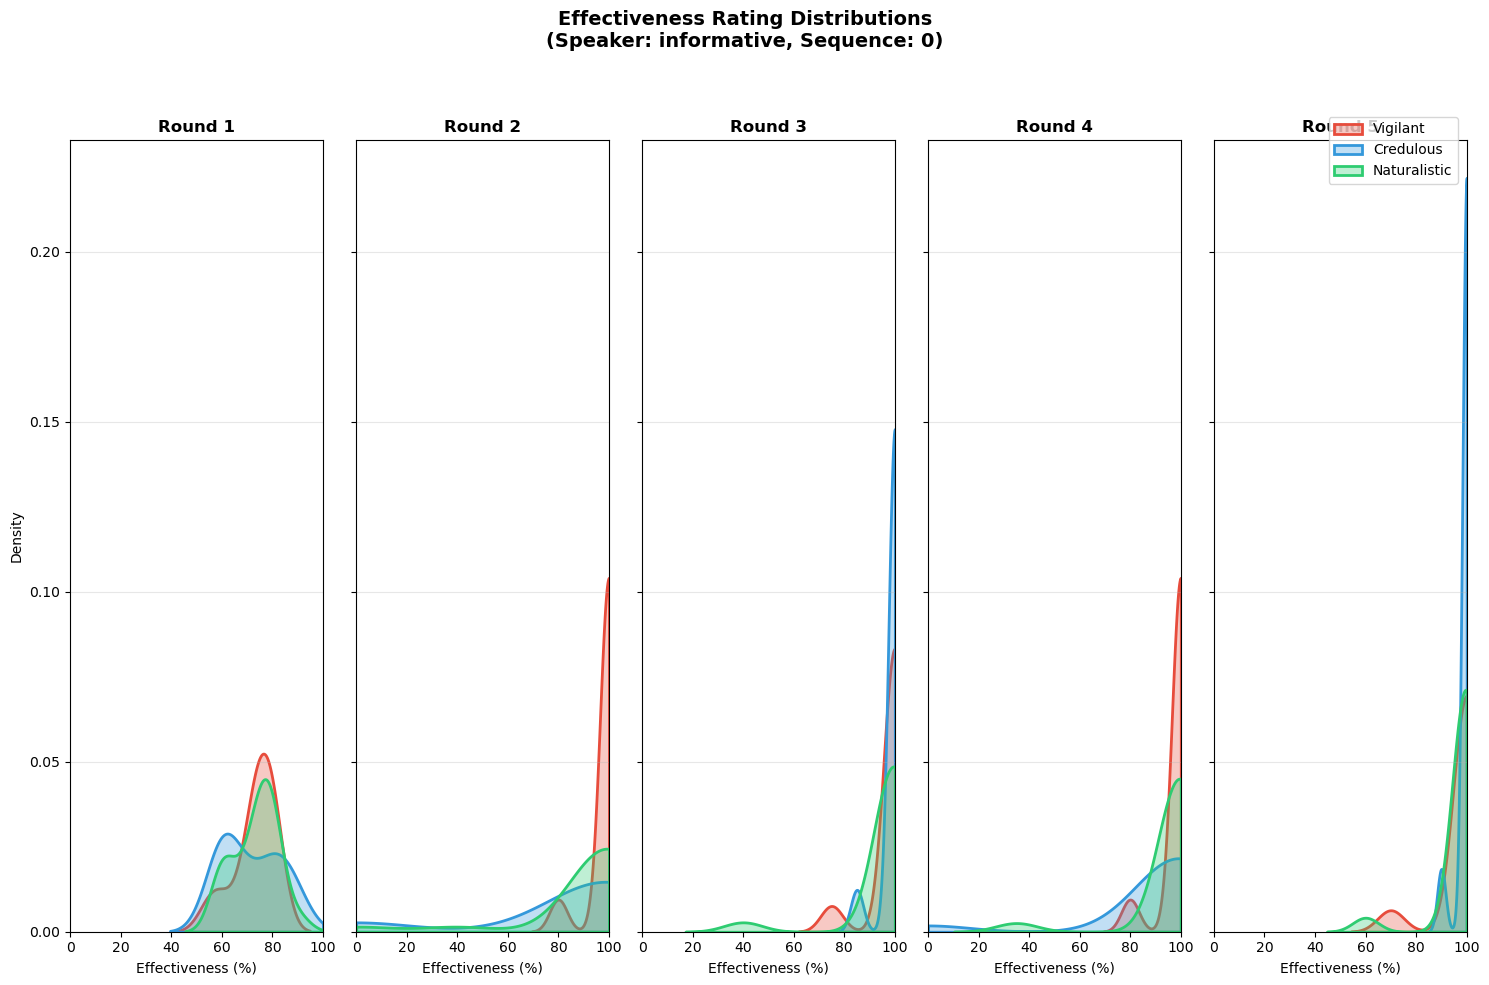

In [254]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'informative', 0)
plt.show()

/var/folders/36/q2gvk7yn00z7g9blzrx_jf_h0000gn/T/ipykernel_17907/2712322625.py:199: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/36/q2gvk7yn00z7g9blzrx_jf_h0000gn/T/ipykernel_17907/2712322625.py:199: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/36/q2gvk7yn00z7g9blzrx_jf_h0000gn/T/ipykernel_17907/2712322625.py:199: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/36/q2gvk7yn00z7g9blzrx_jf_h0000gn/T/ipykernel_17907/2712322625.py:199: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


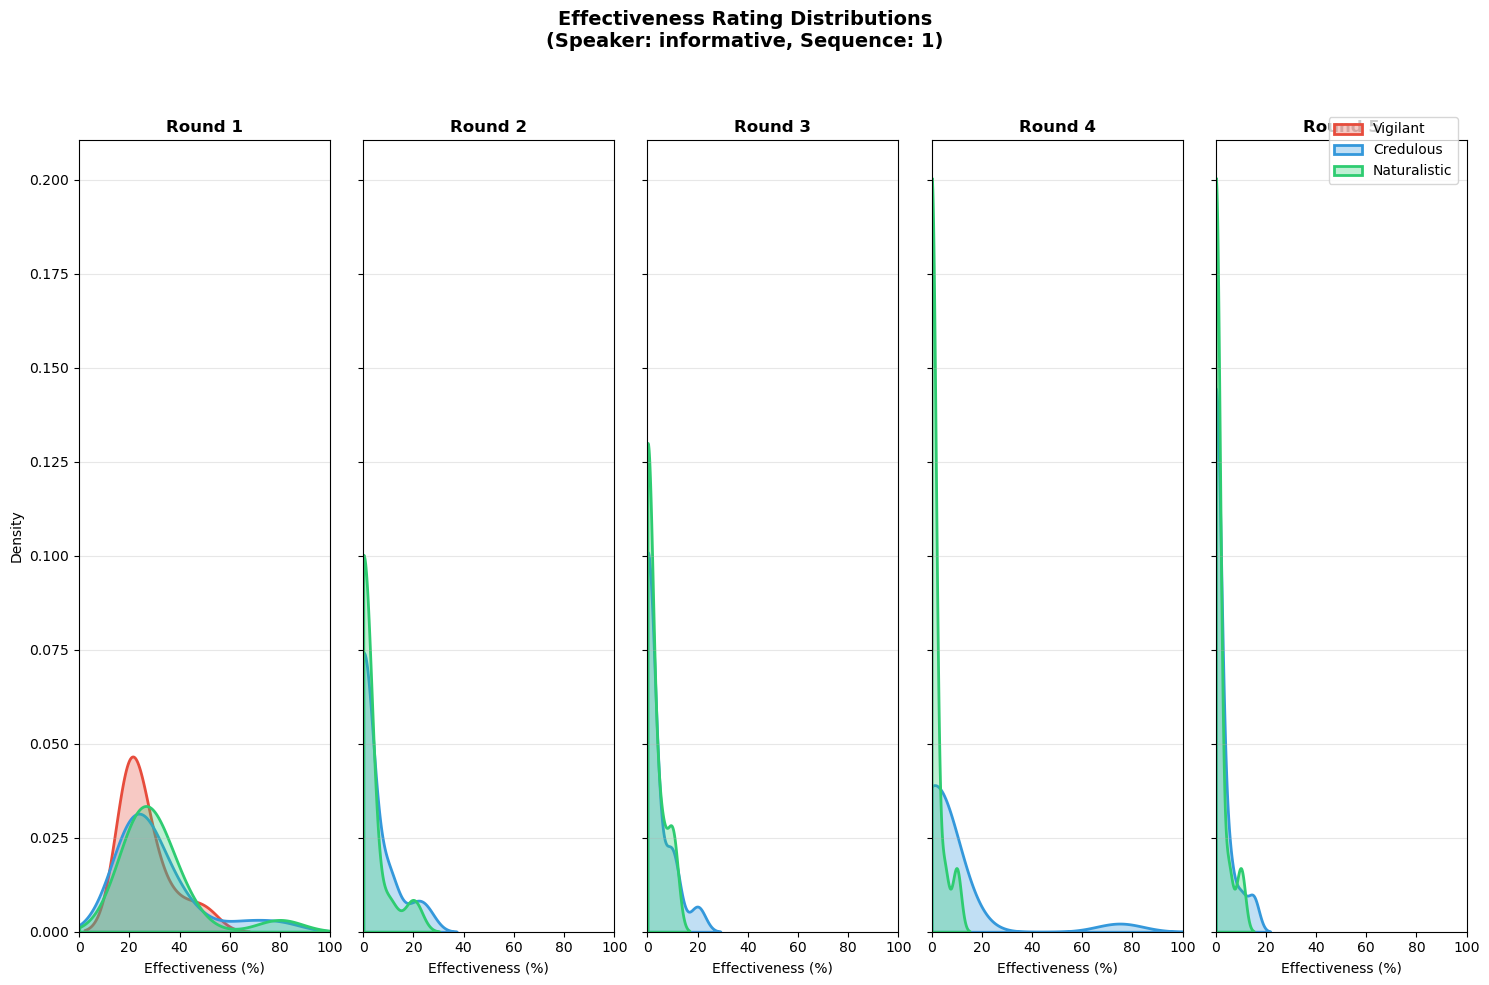

In [260]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'informative', 1)
plt.show()

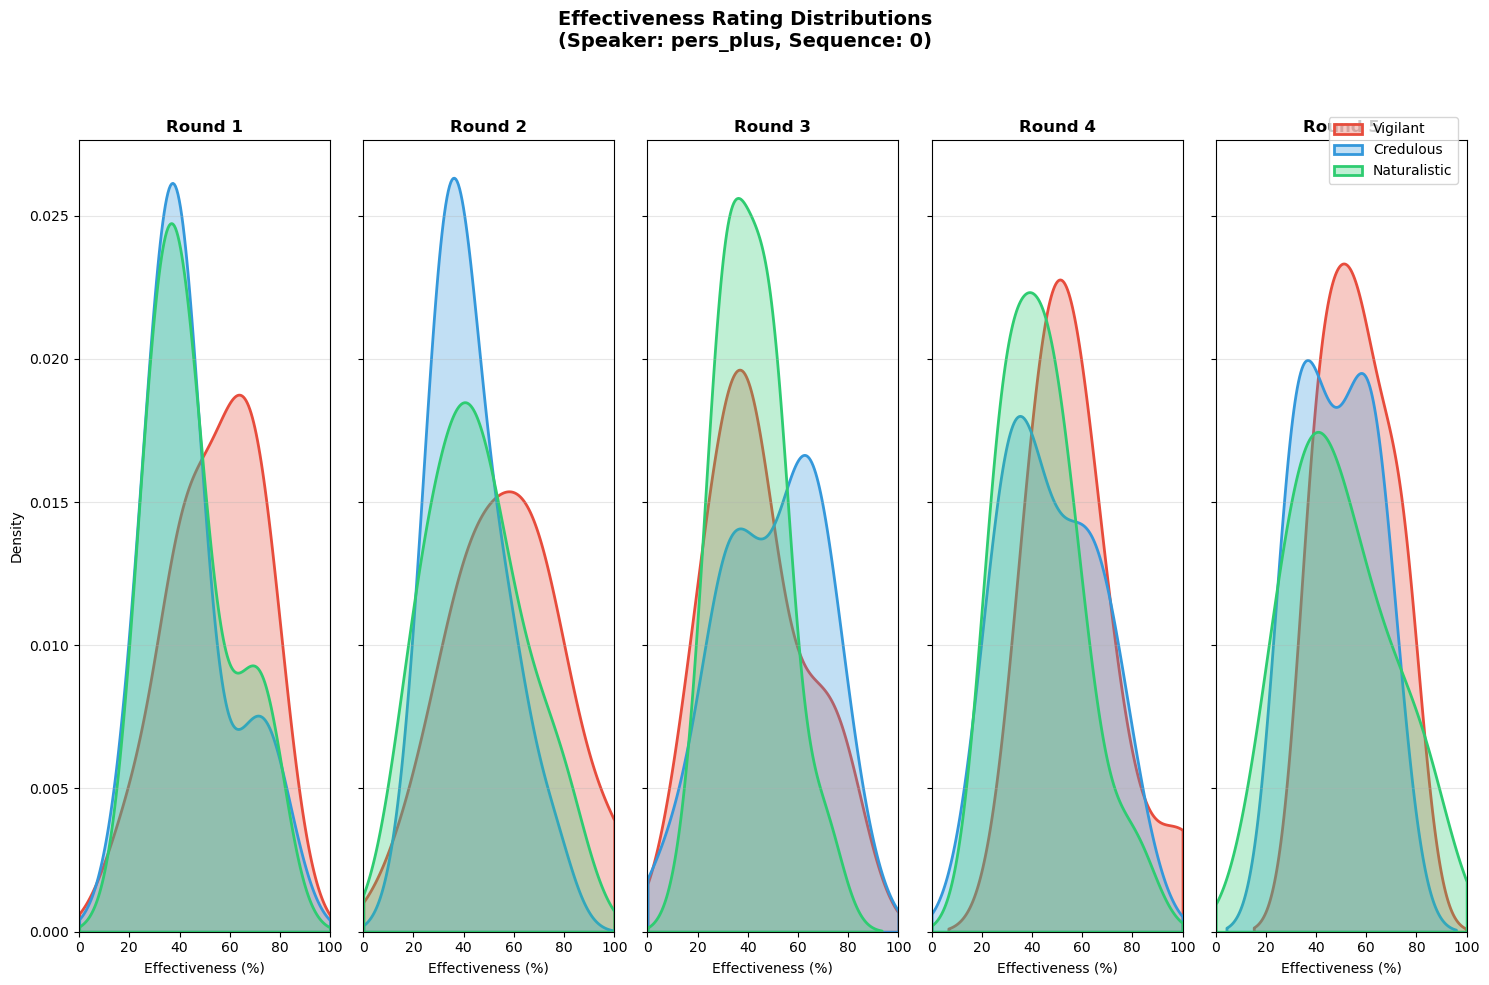

In [261]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'pers_plus', 0)
plt.show()

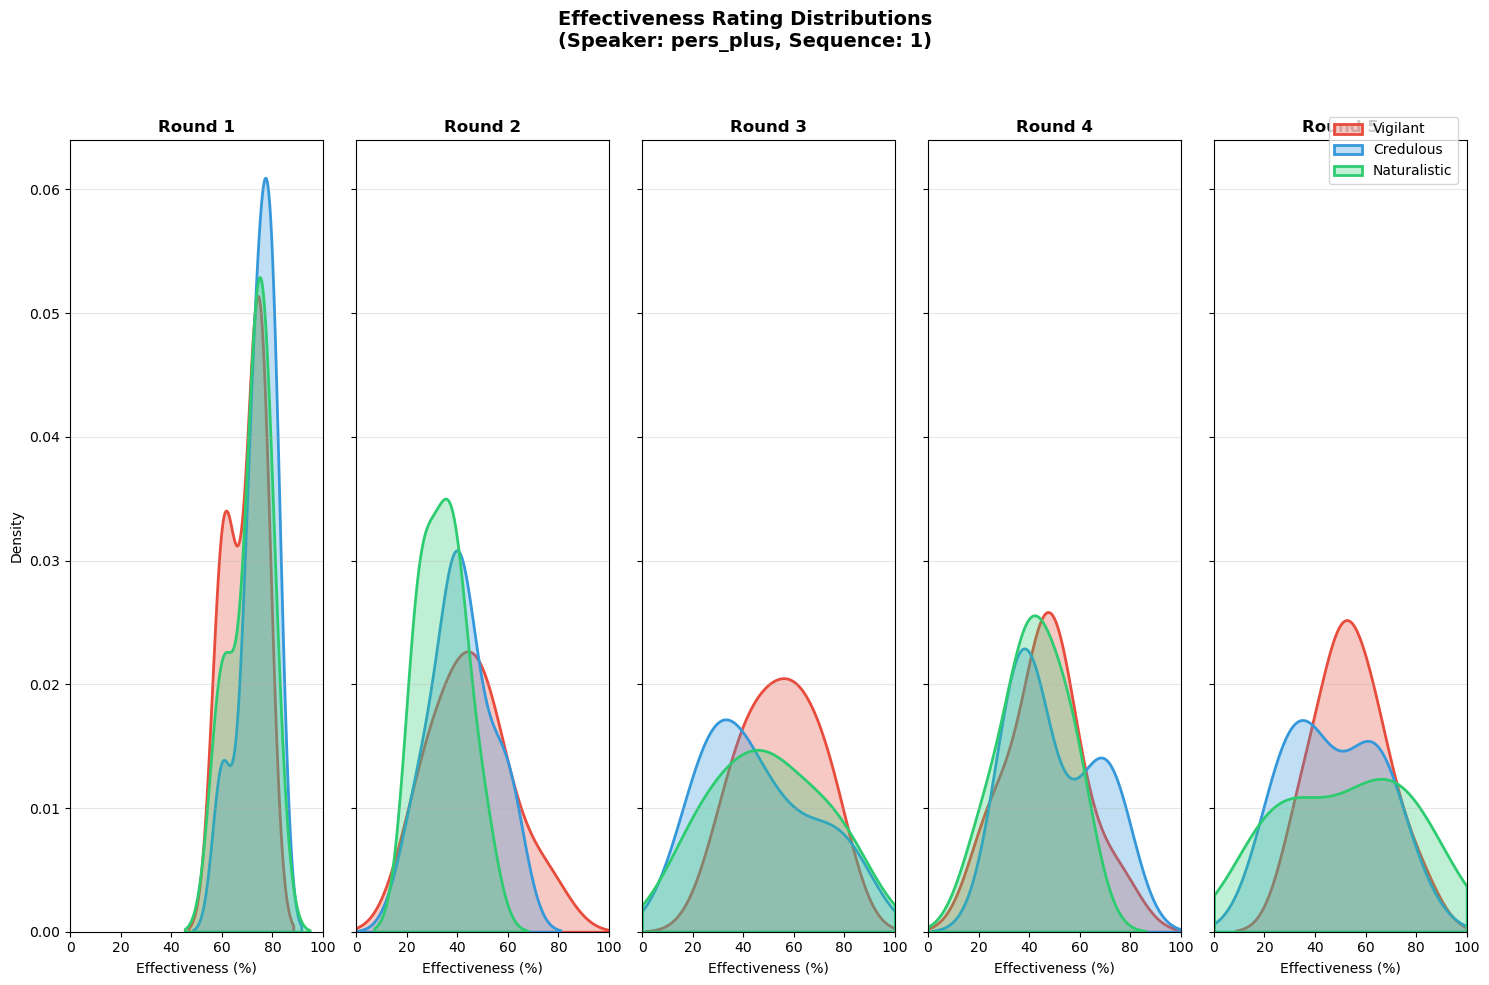

In [262]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'pers_plus', 1)
plt.show()

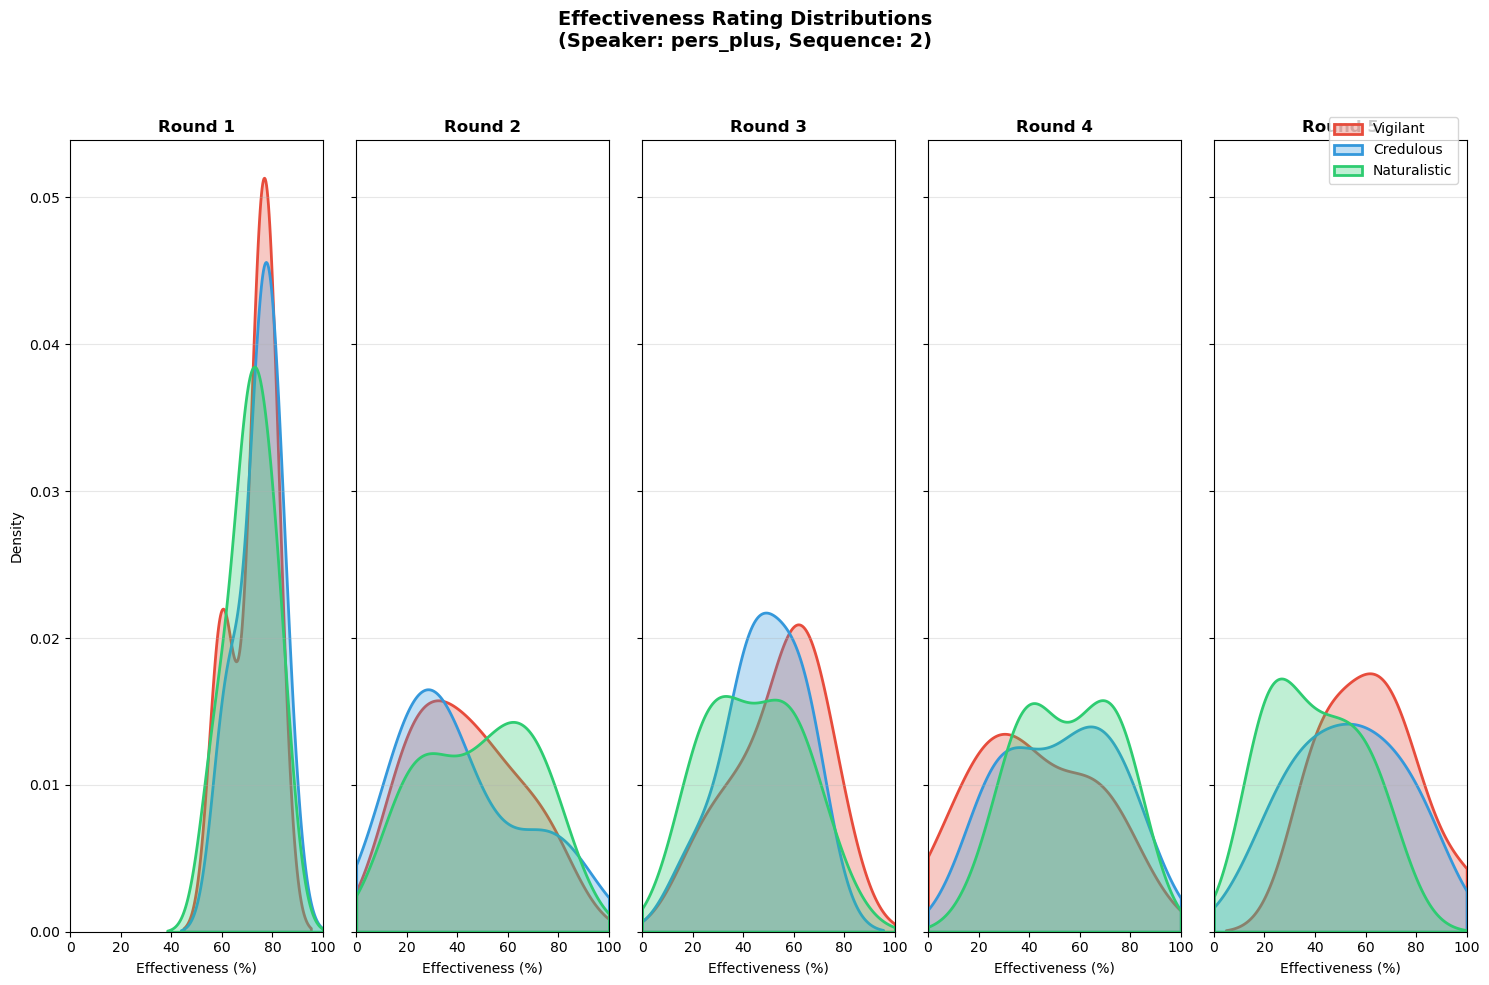

In [263]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'pers_plus', 2)
plt.show()

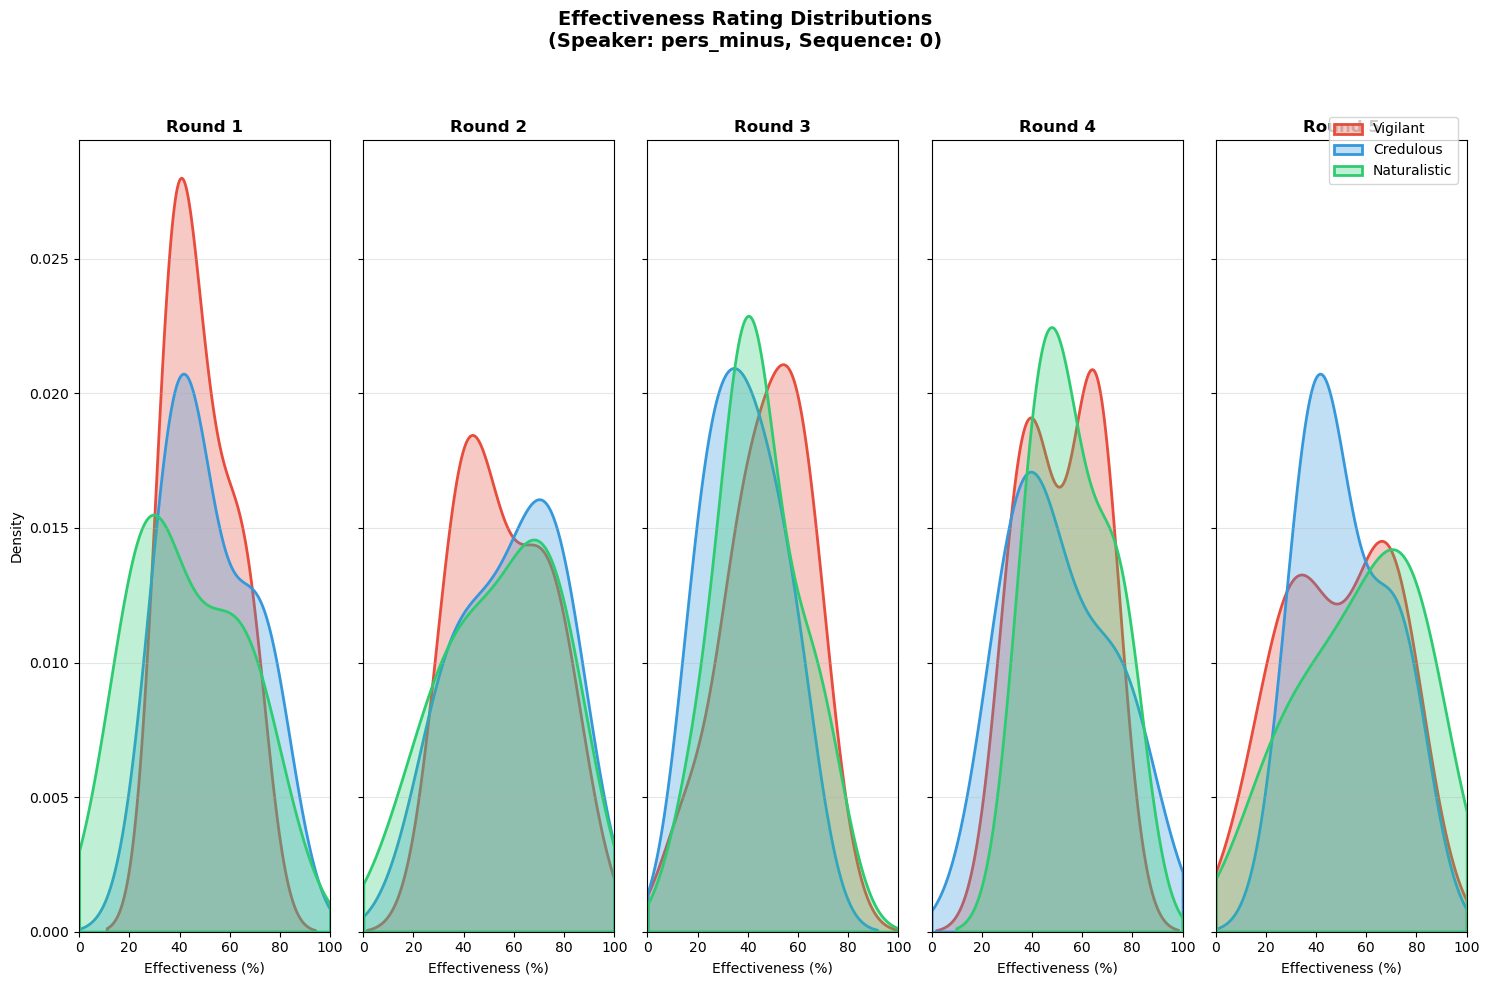

In [264]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'pers_minus', 0)
plt.show()

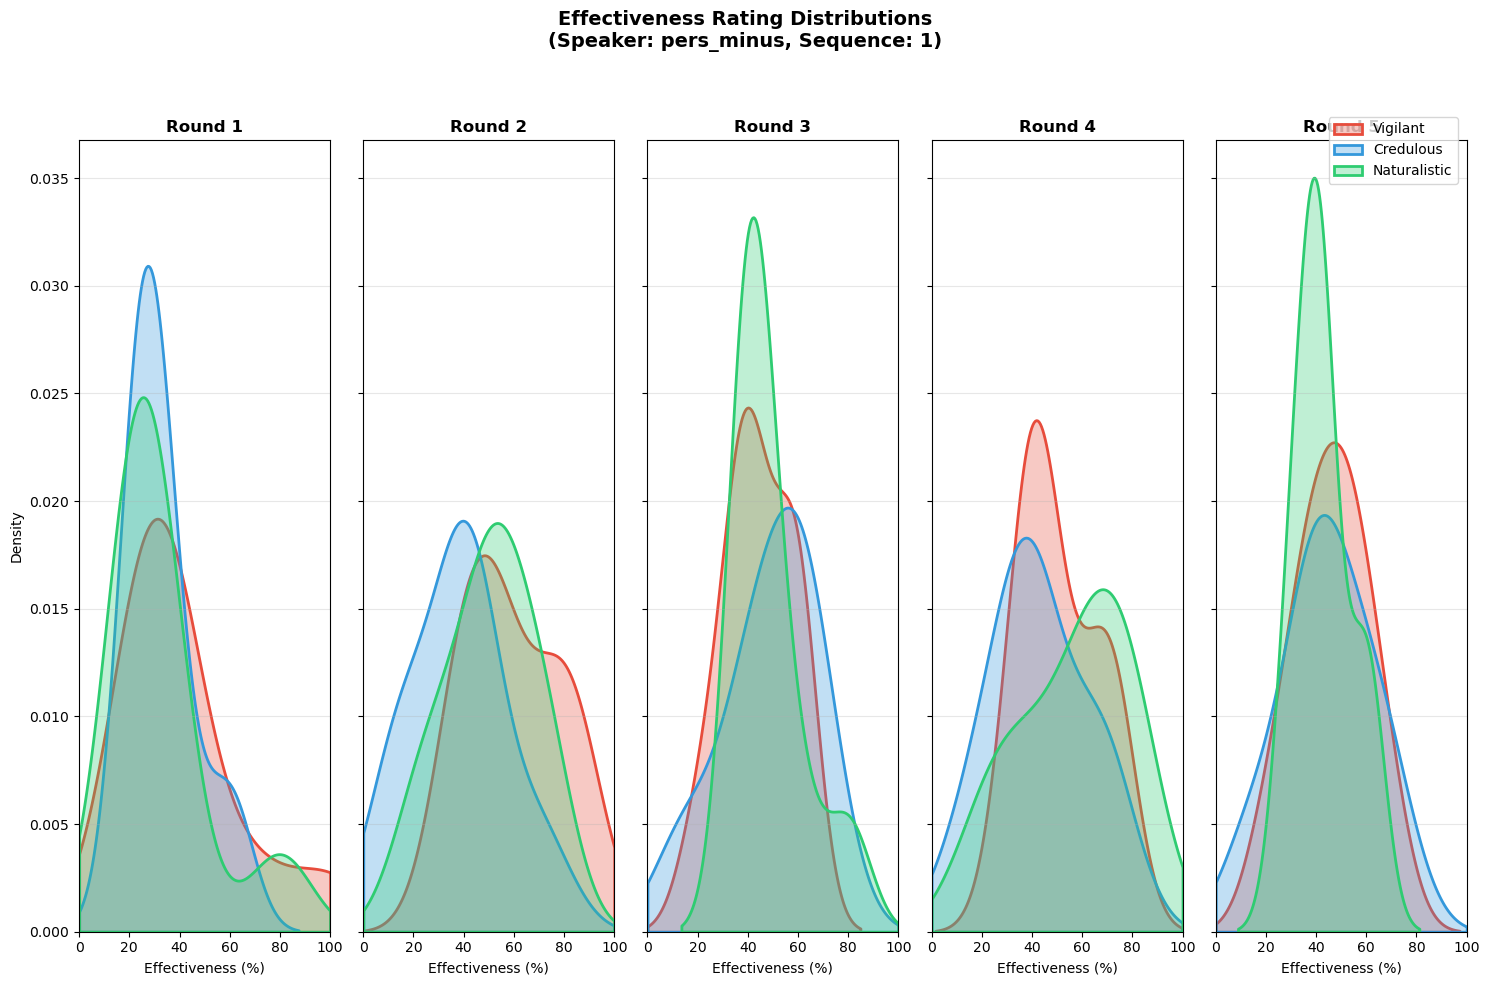

In [265]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'pers_minus', 1)
plt.show()

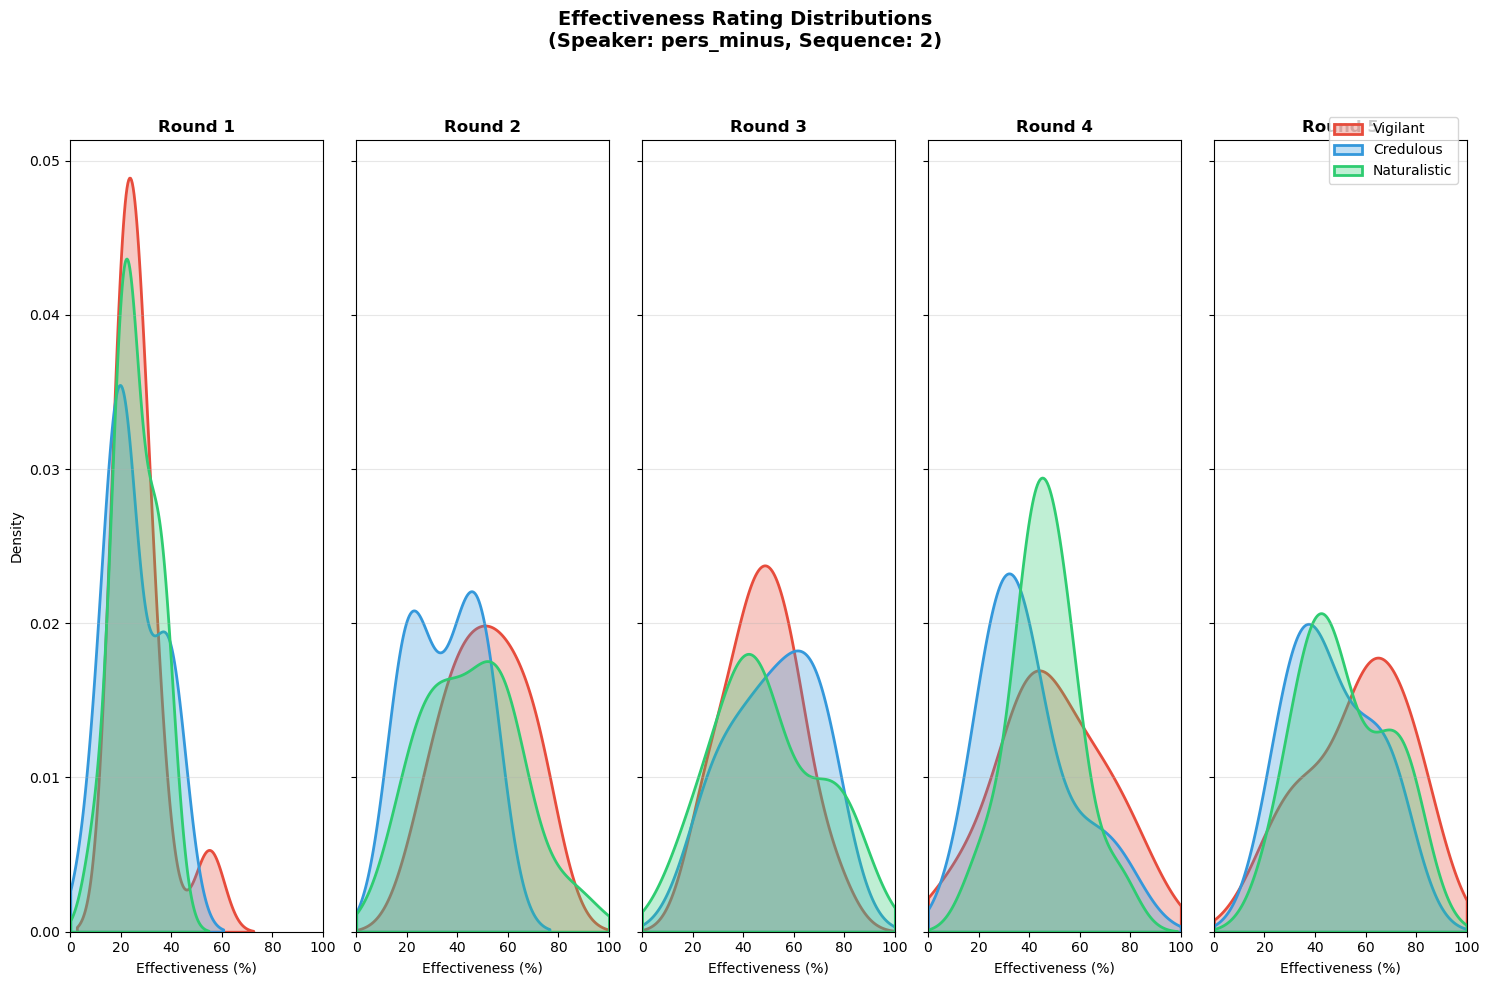

In [266]:
# Plot histograms for a specific sequence
plot_effectiveness_density(df_plot, 'pers_minus', 2)
plt.show()

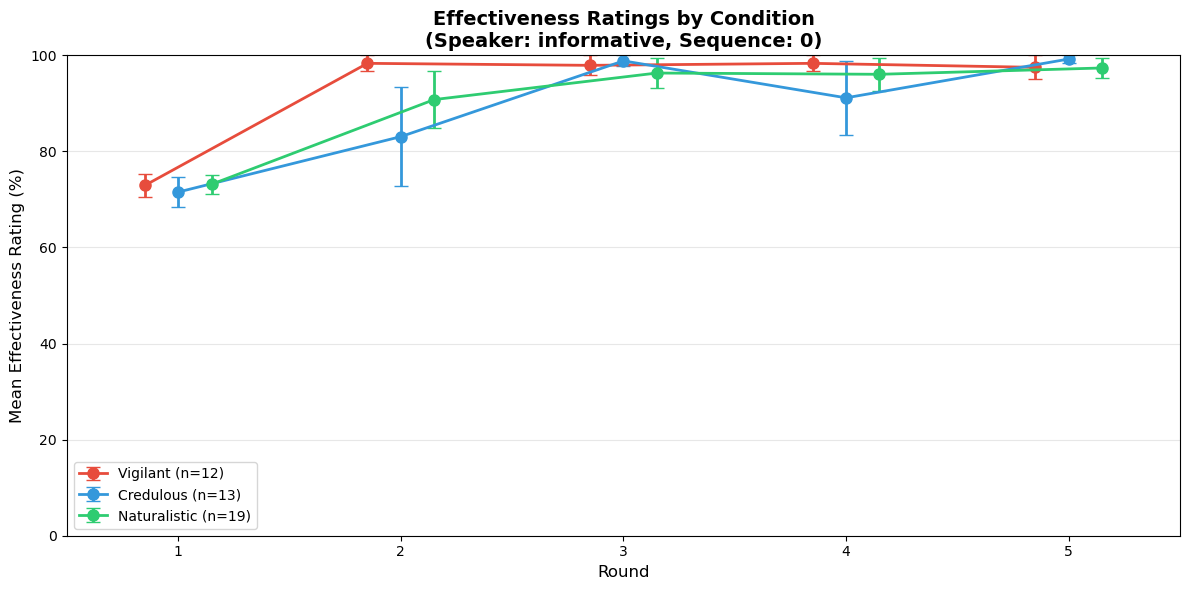

In [267]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'informative', 0)
plt.show()

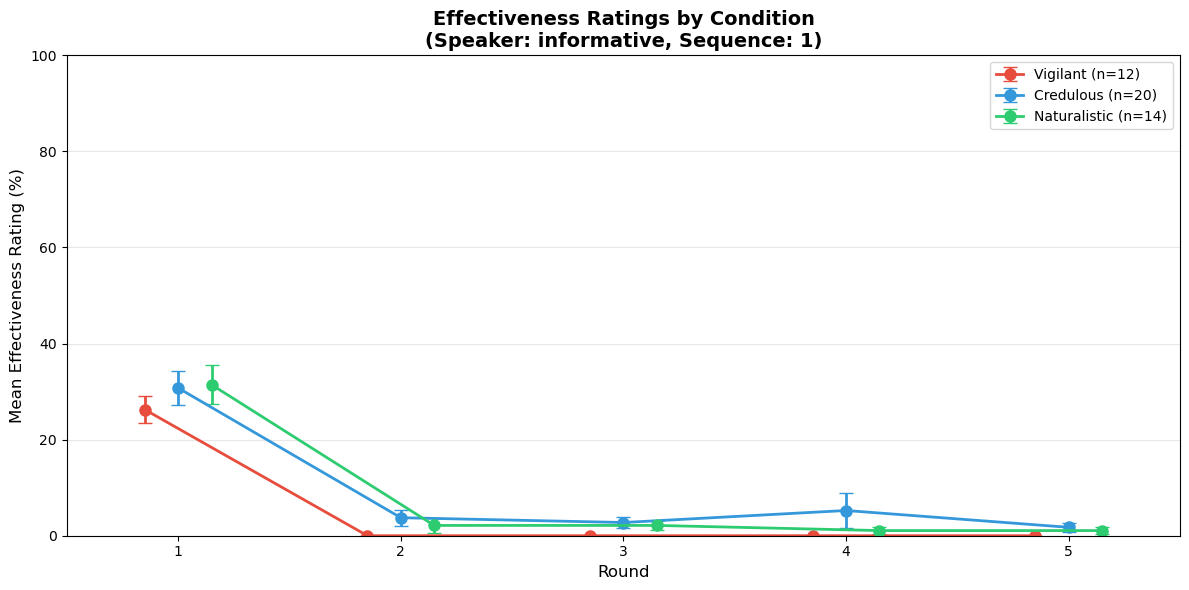

In [268]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'informative', 1)
plt.show()

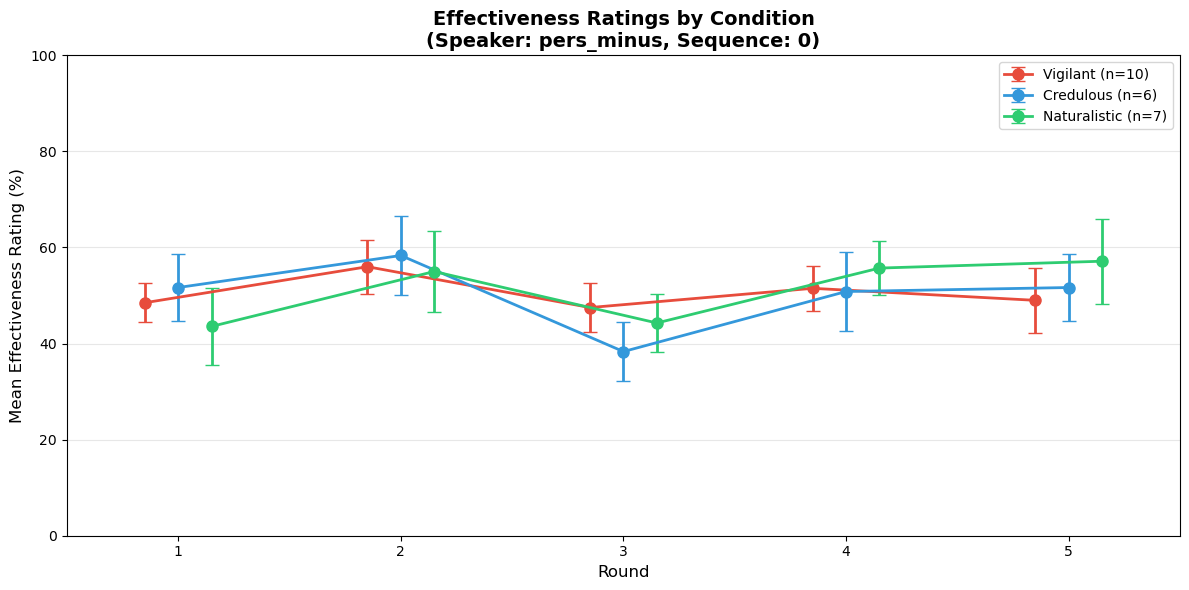

In [269]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'pers_minus', 0)
plt.show()

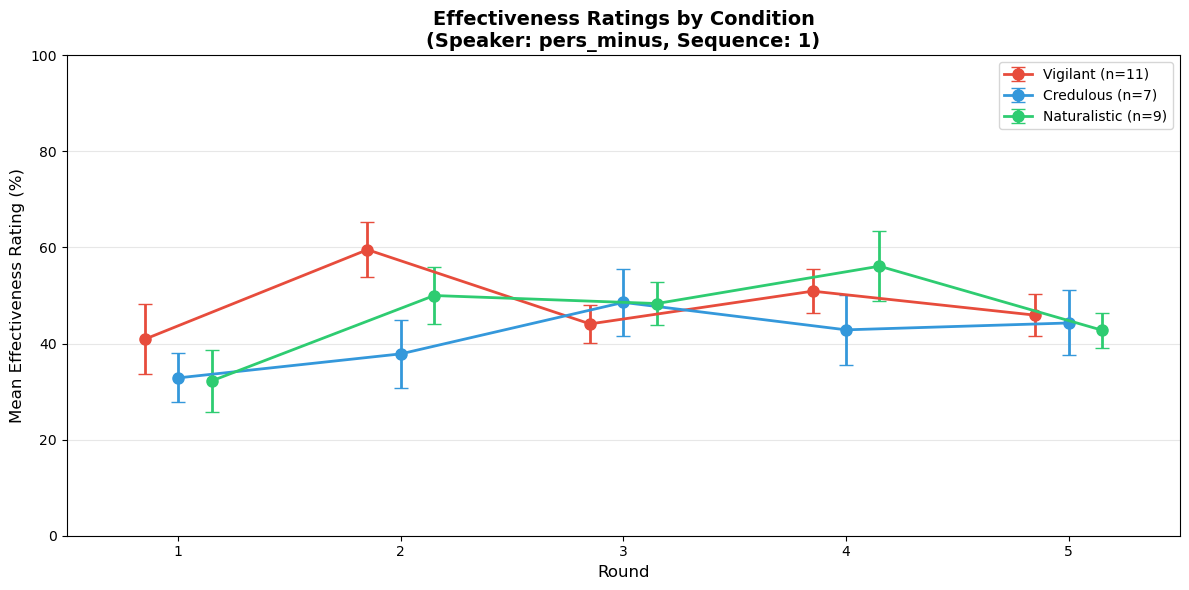

In [270]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'pers_minus', 1)
plt.show()

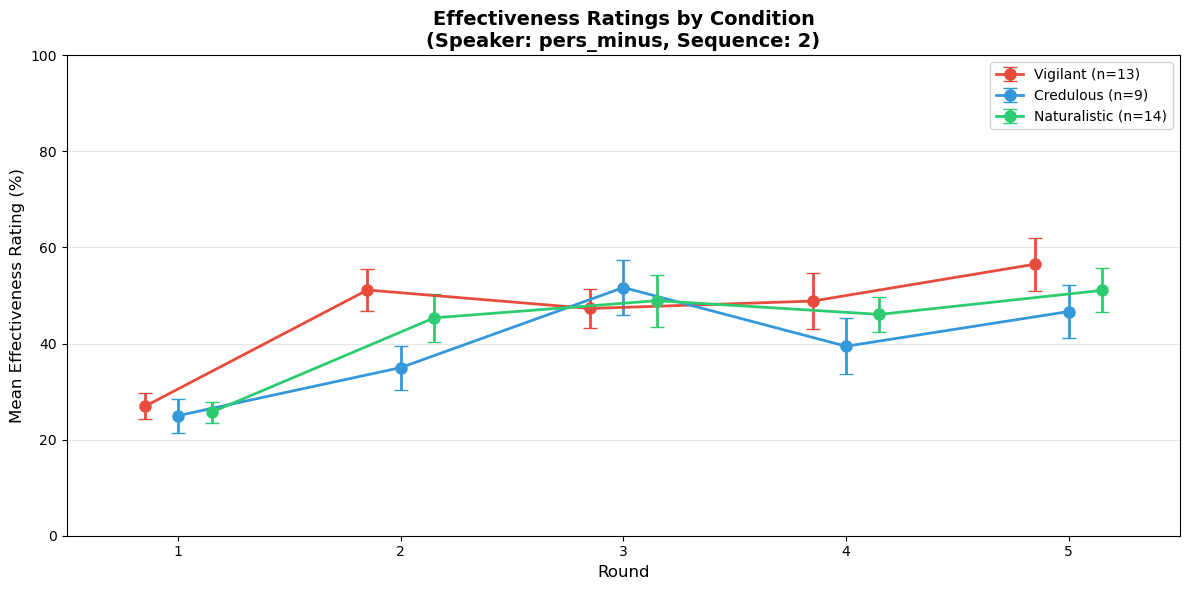

In [271]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'pers_minus', 2)
plt.show()

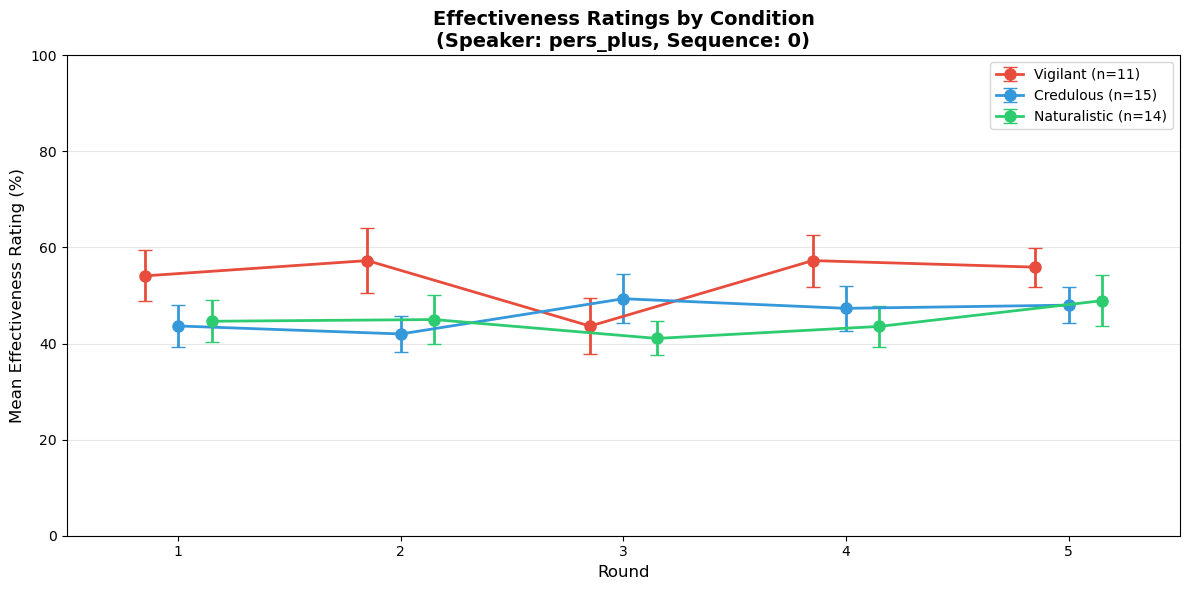

In [272]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'pers_plus', 0)
plt.show()

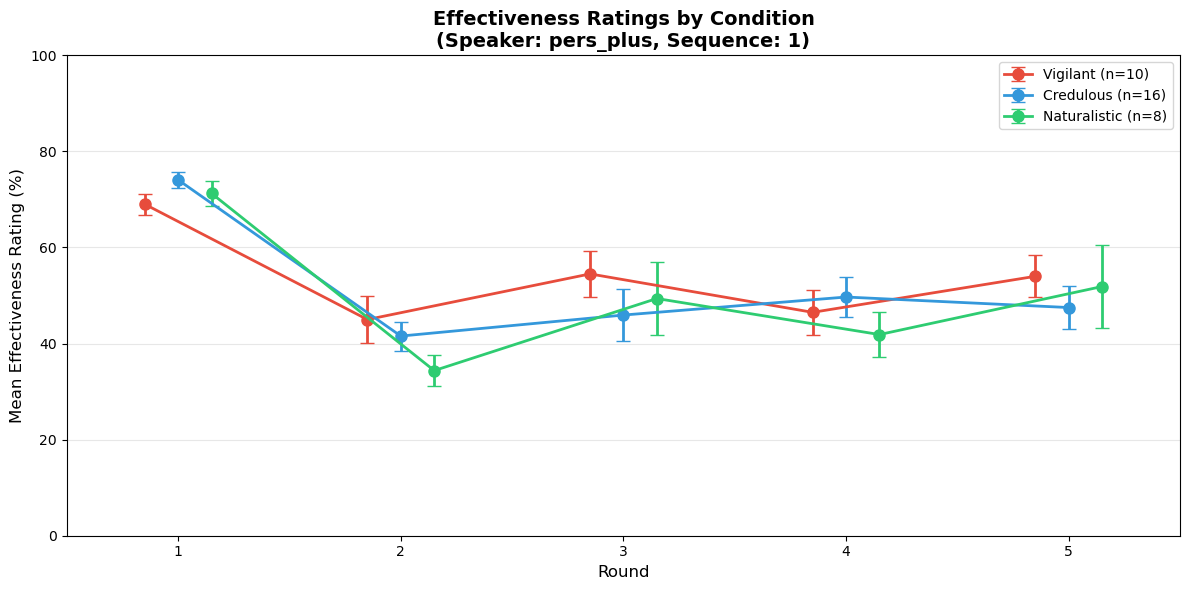

In [273]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'pers_plus', 1)
plt.show()

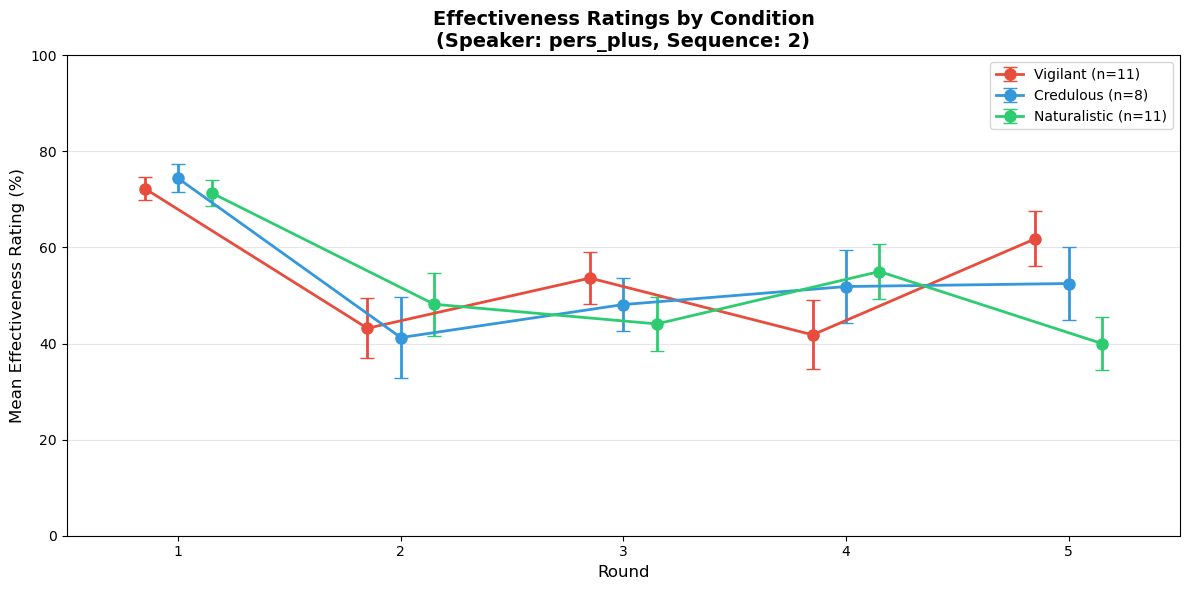

In [274]:
# Plot mean ± SEM summary
plot_effectiveness_summary(df_plot, 'pers_plus', 2)
plt.show()